In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Bước 1: Import Modules

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

# Bước 2: Load bộ dữ liệu NER

Sau khi đọc tập dữ liệu, chúng ta quan sát thử 50 dòng đầu tiên như thế nào.


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Data Scientist/Data/ner_dataset.csv', encoding="latin1")
data = data.fillna(method="ffill")
data.tail(50)


,Sentence #,Word,POS,Tag
1048525,Sentence: 47956,one,NN,O
1048526,Sentence: 47956,was,VBD,O
1048527,Sentence: 47956,injured,VBN,O
1048528,Sentence: 47956,in,IN,O
1048529,Sentence: 47956,Saturday,NNP,B-tim
1048530,Sentence: 47956,'s,POS,O
1048531,Sentence: 47956,incident,NN,O
1048532,Sentence: 47956,but,CC,O
1048533,Sentence: 47956,that,IN,O
1048534,Sentence: 47956,two,CD,O


#Visualizing 
Thông kê bộ dữ liệu:
- Số lượng từ duy nhất trong kho ngữ liệu. (Tập từ vựng, số chiều)
- Số lượng thẻ duy nhất trong tập dữ liệu. (Tập nhãn)


Bằng cách sử dụng hàm **“nunique”.**

In [4]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


Tạo một danh sách và sử dụng phương thức set() để lấy các giá trị trong cột “word” và loại bỏ giá trị trùng.\
Thêm phần đệm có tên “Endpad”.


In [5]:
#tạo tập từ vựng
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [6]:
#tạo tập nhãn tương tự như trên
tags = list(set(data["Tag"].values))
num_tags = len(tags)

# Bước 3: Lấy các câu và các thẻ tương ứng

In [7]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

#Yêu cầu các bạn có thể viết theo cách khác, không dùng code sẵn

In [8]:
def sentencegetter(data):
  sentences = []
  for i in range(47959):
    sentences.append([])
  for i in range(len(data)):
    sentence = data["Sentence #"][i].split(" ")
    index = int(sentence[1])-1
    sentences[index].append((data["Word"][i], data["POS"][i], data["Tag"][i]))
  return sentences 
      

In [9]:
sentences = sentencegetter(data)

In [10]:
# getter = SentenceGetter(data)
# sentences = getter.sentences

# Bước 4: Ánh xạ giữa các câu và chỉ mục
Chúng ta có thể thấy rằng mỗi từ được gán cho một thẻ duy nhất. Chúng tôi có thể truy xuất những từ này bằng cách sử dụng các chỉ số của chúng và tra cứu chúng trong từ điển và trả về các khóa tương ứng.


In [11]:
word2idx = {w: i   for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [12]:
# word2idx
word2idx["ENDPAD"]
tag2idx 

{'I-org': 0,
 'B-tim': 1,
 'I-art': 2,
 'I-nat': 3,
 'O': 4,
 'B-nat': 5,
 'B-per': 6,
 'I-gpe': 7,
 'B-art': 8,
 'B-gpe': 9,
 'B-geo': 10,
 'B-org': 11,
 'I-tim': 12,
 'B-eve': 13,
 'I-eve': 14,
 'I-geo': 15,
 'I-per': 16}

#Bước 5: Padding  đầu vào và cắt dữ liệu thành tập Train/Test\
Trong trục X, có thể thấy độ dài an toàn của câu là khoảng 50.

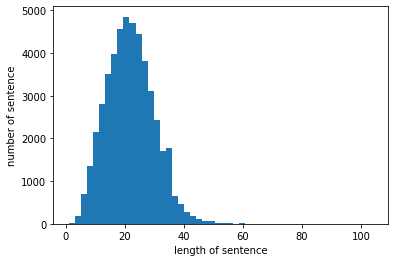

In [13]:
#vẽ biểu đồ thể hiện phân bố chiều dài của câu trong tập dữ liệu.
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel("length of sentence")
plt.ylabel("number of sentence")
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [14]:
#ánh xạ từ trong câu và nhãn về index của nó
from tensorflow.keras.preprocessing.sequence import pad_sequences
#đặt max length cho phù hợp
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

#tương tự với nhãn
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [15]:
print(X[0])
print(y[0])

[ 2529 11220  8555  8346 25385 21537 27743 27711 16013  5043 11866 30375
 30672  3174   362  5043  8262 11220 29545  6103 18652   801 32746 31175
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
[ 4  4  4  4  4  4 10  4  4  4  4  4 10  4  4  4  4  4  9  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4]


- test_size = 0.2 có nghĩa là 80% dữ liệu chia cho tập huấn luyện và 20% còn lại cho tập kiểm tra.

In [16]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

# Bước 6: Xây dựng Mô hình BiGRU


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, GRU
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [18]:
model = Sequential() #Yêu cầu khỏi tạo mạng LSTM 1 chiều
#Input
input_word = Input(shape=(max_len,))
#Embedding
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
#SpatialDropout1D
model = SpatialDropout1D(0.5)(model)
#GRU
model = Bidirectional(GRU(64, return_sequences=True))(model)
#LSTM
model = Bidirectional(GRU(units=100, return_sequences=True, recurrent_dropout=0.5))(model)
#TimeDistributed
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 128)          44544     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 200)          138000    
 nal)                                                            
                                                             

In [19]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#Bước7: Huấn luyện Model

- Để bắt đầu huấn luyện là gọi model.fit ()
- Có thể tăng kích thước batch_size nếu bạn có GPU có kích thước bộ nhớ lớn.



In [20]:
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()

history = model.fit(
    x=x_train,
    y=y_train,
    # validation_data=(x_valid,y_valid),
    validation_split= 0.1,
    batch_size= 32, 
    epochs=1,
    verbose=1
)
print("[{}] Completed!".format(time.time() - start_time))

1080/1080 [==============================] - 383s 344ms/step - loss: 0.1615 - accuracy: 0.9622 - val_loss: 0.0635 - val_accuracy: 0.9813
[383.17595195770264] Completed!


# Bước8: Đánh giá mô hình NER



In [21]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 10s 34ms/step - loss: 0.0620 - accuracy: 0.9814


[0.0620059110224247, 0.9814178347587585]

- Dự đoán

In [22]:
# i = np.random.randint(0, x_test.shape[0]) #659
print(x_test[1])
i =10
p = model.predict(np.array([x_test[i]]))

p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

[ 7395  5815 22569 14811 26395 23343 11220 29849  3174 35060 31175 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
1/1 [==============================] - 1s 1s/step
Word           True 	 Pred

------------------------------
greats         O	O
quieter        O	O
motorbikes     O	O
Neal           O	O
Valdes         O	O
quieter        O	O
leveraged      O	O
Vuk            O	O
remote         O	O
two-man        O	O
Punjab         O	O
quieter        O	O
affront        O	O
flooded        O	O
Yong-Chun      O	O
Sangju         O	O
Qinghai        O	O
quieter        O	O
1996           O	O
Haswa          O	O
salivated      O	O
Valdes         O	O
hypothermia    O	O
Valdes         O	O
bullying       O	O
husbandry      O	O
5,64,000       O	O
SPLM           O	O
republic       O	O
republic       O	O
republic       

In [23]:
from sklearn.metrics import  f1_score

In [24]:
predict = np.argmax(model.predict(x_test), axis=-1)

300/300 [==============================] - 10s 33ms/step


In [25]:
# Đánh giá theo độ đo f1 score: micro 
f1_score(y_test.ravel(), predict.ravel(), average = 'micro')

0.9814178482068391

In [26]:
# Đánh giá theo độ đo f1 score: macro 
f1_score(y_test.ravel(), predict.ravel(), average = 'macro')

0.4639890361752578

In [27]:
# Xuất ra kết quả của F1-score và Accuracy cho từng nhãn thực thể. 
from sklearn.metrics import classification_report

a = {i: t for i, t in enumerate(tags)}
print(classification_report(y_test.ravel(), 
                            predict.ravel(),
                            labels=list(a.keys()), 
                            target_names=list(a.values())))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       I-org       0.66      0.72      0.69      3374
       B-tim       0.92      0.80      0.86      4159
       I-art       0.00      0.00      0.00        66
       I-nat       0.00      0.00      0.00         9
           O       0.99      1.00      1.00    447502
       B-nat       0.00      0.00      0.00        41
       B-per       0.85      0.62      0.72      3406
       I-gpe       0.00      0.00      0.00        38
       B-art       0.00      0.00      0.00        80
       B-gpe       0.93      0.91      0.92      3171
       B-geo       0.81      0.88      0.84      7471
       B-org       0.65      0.64      0.64      4019
       I-tim       0.84      0.55      0.67      1248
       B-eve       0.00      0.00      0.00        56
       I-eve       0.00      0.00      0.00        51
       I-geo       0.87      0.65      0.74      1466
       I-per       0.84      0.78      0.81      3443

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Bước 9: lưu model

Các bạn lưu lại model đã lưu và bộ trong số model

In [29]:
model.save('model_BiGRU_bt1.h5')